In [58]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import gzip
from transformers import pipeline
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
PYDEVD_DISABLE_FILE_VALIDATION=1

In [3]:
# Training Set
trainDF=pd.read_csv("data\\train.csv")

# Validation Set
validationDF=pd.read_csv("data\\validation.csv")

# Testing Set
testDF=pd.read_csv("data\\test.csv")

# Full Data Set
fullDF=pd.read_csv("data\\data.csv")

EMOTIONSDICT={"sadness":0, "joy":1, "love":2, "anger":3, "fear":4, "surprise":5}

In [49]:
class NaiveBayes(object):
    
    def __init__(self, df, alpha=1):
        self.vocabulary={} #Set that contains all vocabulary words in our training set.
        self.sentences=self.createSparseMat(df) #Tokenized representation of all sentences in dataframe.
        self.targets=self.createTargets(df) #Targets for each sentence, corresponding to the labelled emotions.

        self.numSamples=self.sentences.shape[0] #Number of sentences, N.
        self.numFeatures=self.sentences.shape[1] #Number of words in our vocabulary, D.
        self.numTargets=max(self.targets)+1 #Number of different sentiments, C.
        self.alpha=alpha #Alpha of smoothing.
        self.labelledSentences=self.createLabelledSentences() #Dictioanry, CxN_cxD, where each key represents
            #an emotion and holds an array of all sentences that are labelled that emotion.
        self.wordFrequencies=self.createWordFrequencies() #CxD dimensional array, where each array is the sum
            #of the d-th word across all sentences of class c.
        self.totalWordFrequencies=self.createTotalWordFrequencies() #C dimensional array, where each index is the 
            #sum of all words in sentences of class c.
            
        self.priorProbabilities=None #Prior probabilities.
        self.posteriorProbabilities=None #Posterior probabilities, multinomial.
        
    #Creates word frequencies list.
    def createWordFrequencies(self):
        res=[0]*self.numTargets
        for c in range(self.numTargets):
            res[c]=np.sum(self.labelledSentences[c], axis=0)
        return res
    
    #Creates total word frequencies list.
    def createTotalWordFrequencies(self):
        res=[0]*self.numTargets
        for c in range(self.numTargets):
            res[c]=np.sum(self.labelledSentences[c])
        return res
    
    #Return dictionary with keys that are the targets, and entries being arrays of all sentences that are 
        #that target. 
    def createLabelledSentences(self):
        res=dict.fromkeys(range(self.numTargets+1))
        for key in res:
            res[key]=[]
        for i in range(len(self.sentences)):
            target=self.targets[i]
            res[target].append(self.sentences[i])
        return res
    
    #Returns a bag of words matrix representation of each sentence in our dataset.
    def createSparseMat(self, df, test=0):
        
        phrases=[]
        for i in range(len(df)):
            sample=df.loc[i, "text"]
            phrases.append(sample)
            
        #If we're testing, we need to use the vocabulary from our training set to make the sparse matrix.
        vectorizer=None
        if test:
            vectorizer=CountVectorizer(vocabulary=self.vocabulary)
            sparseMat=vectorizer.fit_transform(phrases)
            return sparseMat.toarray()
        else:
            vectorizer=CountVectorizer()
            sparseMat=vectorizer.fit_transform(phrases)
            self.vocabulary=vectorizer.vocabulary_
            return sparseMat.toarray()
    
    #Creates corresponding targets to each sentence.
    def createTargets(self,df):
        labels=[]
        for i in range(len(df)):
            labels.append(df.loc[i,"emotions"])
        return labels
    
    #Creates and stores parameters as model attributes.
    def fit(self):
        priorProbabilities=self.createPriorProbabilities()
        self.priorProbabilities=priorProbabilities
        
        posteriorProbabilities=self.createPosteriorProbabilities()
        self.posteriorProbabilities=posteriorProbabilities
        
    #Creates prior probabilities of each emotion using multinoulli classification. 
    def createPriorProbabilities(self):
        priorProbabilities=[self.alpha]*self.numTargets
        for i in range(len(self.targets)):
            trueTarget=self.targets[i]
            priorProbabilities[trueTarget]+=1
        return np.divide(priorProbabilities, self.alpha*self.numTargets+self.numSamples)

    #Creates posterior probabilites, the theta_(d,c).
    def createPosteriorProbabilities(self):
        posteriorProbabilites=[[0]*self.numFeatures for c in range(self.numTargets)] #CxD
        
        for c in range(self.numTargets):
            posteriorProbabilites[c]=np.divide(self.wordFrequencies[c]+self.alpha, self.alpha*self.numTargets+self.totalWordFrequencies[c])
        
        return posteriorProbabilites
    
    #Predicts the labels for a test/validation dataframe.
    def predict(self, testdf):
        testMatrix=self.createSparseMat(testdf, test=1)
        predictedTargets=[]
        
        for i in range(len(testMatrix)):
            sentence=testMatrix[i]
            probabilities=self.predictSentence(sentence)
            predictedEmotion=probabilities.index(max(probabilities))
            predictedTargets.append(predictedEmotion)
            
        return predictedTargets

    #Gets accuracy for a test dataframe.
    def getAcc(self, testdf):
        testTargets=self.createTargets(testdf)
        predictedTargets=self.predict(testdf)
        
        right=0
        for i in range(len(testTargets)):
            if testTargets[i]==predictedTargets[i]:
                right+=1
        return right/len(testTargets)
    
    #Returns probability of sentence being each class c.
    def predictSentence(self, sentence):
        probabilities=[0]*self.numTargets
        
        for c in range(self.numTargets):
            res=1
            res*=self.priorProbabilities[c] #Probability of it being class c.
            for d in range(self.numFeatures):
                factor=self.posteriorProbabilities[c][d]**(sentence[d])
                res*=(factor) #Posterior probabilities.
            probabilities[c]=res
           
        pSum=sum(probabilities) 
        for i in range(len(probabilities)):
            probabilities[i]=probabilities[i]/pSum
            
        return probabilities
        

C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_22420\3872390070.py:137: RuntimeWarning: invalid value encountered in scalar divide
  probabilities[i]=probabilities[i]/pSum


Text(0.5, 1.0, 'Test Set Accuracy For Various Smoothing Alphas')

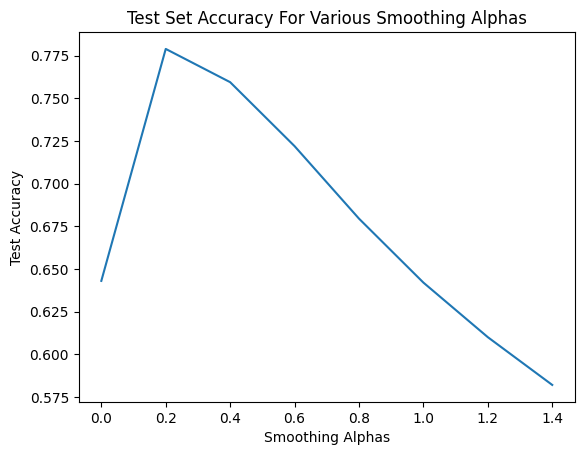

In [62]:
alphas=[]
testAccs=[]
for alpha in range(0, 15, 2):
    alphas.append(alpha/10)
    bayesModel=NaiveBayes(trainDF, alpha/10) #Training model
    bayesModel.fit()
    testAccs.append(bayesModel.getAcc(testDF))
    
plt.plot(alphas, testAccs)
plt.xlabel("Smoothing Alphas")
plt.ylabel("Test Accuracy")
plt.title("Test Set Accuracy For Various Smoothing Alphas")

In [5]:
#Importing pre-trained model without changing weights. 
bert = pipeline("sentiment-analysis",model='bhadresh-savani/bert-base-uncased-emotion')

testModel=NaiveBayes(testDF, 2)

right=0
for i in range(len(testModel.sentences)):
    sentence=testDF.loc[i,"text"]
    prediction=bert(sentence)
    predictedTarget=EMOTIONSDICT[prediction[0]["label"]]
    if predictedTarget==testModel.targets[i]:
        right+=1

print("Accuracy is:", right/len(testDF))

Accuracy is: 0.9265


In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader, TensorDataset, Dataset
from pandatorch import data
import evaluate

In [25]:
#Creating the model and tokenizer.
modelName='bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(modelName)
model = BertForSequenceClassification.from_pretrained(modelName, num_labels=6)

def tokenizeFunction(sentence):
    return tokenizer(sentence, padding="max_length", truncation=True)

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer=tokenizer
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.loc[idx, "text"]  # 'text' column
        emotions = self.data.loc[idx, "emotions"]  # 'emotions' column
        inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs["input_ids"].squeeze(),
            'attention_mask': inputs["attention_mask"].squeeze(),
            'labels': int(emotions),
        }

#Tokenizing the training and text strings
trainDataset=CustomDataset(trainDF, tokenizer)
testDataset=CustomDataset(testDF, tokenizer)
trainLoader=DataLoader(trainDataset, batch_size=16, shuffle=True)
testLoader=DataLoader(testDataset, batch_size=16, shuffle=True)

NameError: name 'BertTokenizer' is not defined

In [11]:
#Implementing pre-trained model, with changing weights.

#Loading evaluation metrics.
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


#Creating training configurations for the model.
trainingArgs= TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    save_steps=500,
    eval_steps=500,
)

#Creating a trainer for the model, prints out accuracy.
trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=trainDataset,
    eval_dataset=testDataset,
    compute_metrics=compute_metrics
)

In [12]:
#Printing results of training of evaluation dataset.
results = trainer.evaluate(eval_dataset=testDataset)
print(results)
#93.75 

  2%|▏         | 4/250 [00:34<39:22,  9.61s/it]

KeyboardInterrupt: 